In [ ]:
import os
os.environ['PYTHONHASHSEED'] = '0'
import tensorflow as tf
tf.random.set_seed(42)
#probably not needed
tf.keras.utils.set_random_seed(42)  # sets seeds for base-python, numpy and tf
tf.config.experimental.enable_op_determinism()
import random
random.seed(42)
import numpy as np
np.random.seed(42)

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
import plotly.offline as pyo
from plotly import subplots
import plotly.graph_objects as go
from baseFunctions import *
import statsmodels.api as sm
import statsmodels.tsa.api as smt

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_log_error

In [ ]:
from keras.models import Model
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Input,concatenate
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
train = pd.read_csv('../train.csv')
oil = pd.read_csv('../oil.csv')
stores = pd.read_csv('../stores.csv')
transactions = pd.read_csv('../transactions.csv')
test = pd.read_csv('../test.csv')
holidays = pd.read_csv('../holidays_events.csv')
sampleSub = pd.read_csv('../sample_submission.csv')

# merge data (ignore transactions for now)

In [ ]:
# prepare data

train['dataT'] = 'train'
test['dataT'] = 'test'
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])
data = pd.concat([train, test])
data['date'] = pd.to_datetime(data['date'])

data0 = pd.merge(data, stores, on=['store_nbr'], how='outer')
print(data.shape, data0.shape)

oil['date'] = pd.to_datetime(oil['date'])
oil.set_index('date',inplace=True)
oil_resampled = oil.resample('1D').asfreq()
print(oil_resampled.isna().sum())
oil_resampled.interpolate(inplace=True,limit_direction='both')
oil_resampled.reset_index(inplace=True)
print(oil_resampled.isna().sum())

data0['date'] = pd.to_datetime(data0['date'])
data1 = pd.merge(data0, oil_resampled, on=['date'], how='left')
print(data1.shape, data0.shape)

holidays['date'] = pd.to_datetime(holidays['date'])
cityHolidays = holidays.loc[holidays.locale =='Local']#.locale_name.value_counts()
cityHolidays.drop('locale', axis = 1, inplace=True)
cityHolidays['description'] = 'Fundacion'
cityHolidays.rename(columns={'locale_name':'city','type':'holidayType'}, inplace=True)
cityHolidays.drop(264, axis = 0, inplace=True) # we have some duplicates
data2 = pd.merge(data1, cityHolidays, on=['date','city'], how='left')
#train2.dropna(inplace=True)
print(data1.shape, data2.shape)

regionalHolidays = holidays.loc[holidays.locale =='Regional']#.locale_name.value_counts()
regionalHolidays.drop('locale', axis = 1, inplace=True)
regionalHolidays['description'] = 'Provincializacion'
regionalHolidays.rename(columns={'locale_name':'state'}, inplace=True)

data3 = pd.merge(data2, regionalHolidays, on=['date','state'], how='left', suffixes=('','_reg'))
print(data3.shape, data2.shape)

nationalHolidays = holidays.loc[holidays.locale =='National']#.locale_name.value_counts()
nationalHolidays.drop(['locale','locale_name'], axis = 1, inplace=True)
nationalHolidays.description.unique()
groups = ['Navidad', 'Mundial de futbol Brasil','Terremoto Manabi','dia del ano','Puente Dia de Difuntos','Grito de Independencia','Independencia de Guayaquil','Dia de la Madre','Batalla de Pichincha']
for group in groups:
    mask = nationalHolidays['description'].str.contains(group)
    nationalHolidays.loc[mask, 'description'] = group
nationalHolidays = nationalHolidays.drop_duplicates(subset=['date'], keep='first')

data4 = pd.merge(data3, nationalHolidays, on=['date'], how='left', suffixes=('','_nat'))
print(data3.shape, data4.shape)


data5 = data4.copy()
data5['holidayType'] = data5['holidayType'].combine_first(data5['type_reg'])
data5['holidayType'] = data5['holidayType'].combine_first(data5['type_nat'])

data5['description'] = data5['description'].combine_first(data5['description_reg'])
data5['description'] = data5['description'].combine_first(data5['description_nat'])

data5['transferred'] = data5['transferred'].combine_first(data5['transferred_reg'])
data5['transferred'] = data5['transferred'].combine_first(data5['transferred_nat'])

data5 = data5.drop(columns=['type_reg','type_nat','description_reg','description_nat','transferred_reg','transferred_nat'])

print(data4.shape, data5.shape)

data6 = data5.copy()
propDicts = {}
for f in ['family','city','state','type','holidayType','description','transferred']:
    unique = data6[f].unique()
    category_dict = {category: index for index, category in enumerate(unique)}
    data6[f] = data6[f].map(category_dict)
    propDicts[f] = category_dict

flippedPropDicts = {}
for key,value in propDicts.items():
    flippedPropDicts[key] = {value: key for key, value in propDicts[key].items()}


In [ ]:
del data, data0, data1, data2, data3, data4, data5, transactions, train, oil, test, sampleSub, holidays

## sanity checks

In [ ]:
# check that the city holidays are the same in the holiday and store df
uniqueLocalsHolidays = holidays.loc[holidays.locale =='Local'].locale_name.unique()
uniqueLocalCities = stores.city.unique()

intersection = set(uniqueLocalsHolidays).intersection(set(uniqueLocalCities))
not_intersection_list1 = set(uniqueLocalsHolidays).difference(intersection)
not_intersection_list2 = set(uniqueLocalCities).difference(intersection)

print(intersection)
print(not_intersection_list1)
print(not_intersection_list2)
#result: we have a couple cities without holidays, but that is fine, the rest is the same 

In [ ]:
# Sanity check, somewhat ok
rows = train4.shape[0]
holTypes = rows - train4.holidayType.isna().sum()
holTypes1 = rows - train4.type_reg.isna().sum()
holTypes2 = rows - train4.type_nat.isna().sum()
sumTypes = holTypes + holTypes1 + holTypes2
print(sumTypes, rows - train5.holidayType.isna().sum())

holTypes = rows - train4.description.isna().sum()
holTypes1 = rows - train4.description_reg.isna().sum()
holTypes2 = rows - train4.description_nat.isna().sum()
sumTypes = holTypes + holTypes1 + holTypes2
print(sumTypes, rows - train5.description.isna().sum())

holTypes = rows - train4.transferred.isna().sum()
holTypes1 = rows - train4.transferred_reg.isna().sum()
holTypes2 = rows - train4.transferred_nat.isna().sum()
sumTypes = holTypes + holTypes1 + holTypes2
print(sumTypes, rows - train5.transferred.isna().sum())

# check how to make data staionary

In [ ]:
testPair = train.loc[(train.store_nbr == 6) & (train.family == 'BEAUTY')]
testPair.set_index('date', inplace=True)

In [ ]:
testPair.sales.diff(14).plot()

In [ ]:
# peak at 14 -> predict 2 week difference
# ACF: MA (moving average) part = how many last errors we include, e.g. error at t-1, t-2,.. -> 3-4 last erors
# PACF: AR (autoregressive) part = how many lags we include                                  -> 3 lags
tsplot(testPair.sales.diff(14).dropna(),lags = 15)

In [ ]:
test_stationarity(testPair.sales.diff(14).dropna())

# preparing data

In [ ]:
testPair['target'] = testPair.sales.diff(14)
testPair['shiftedSales14'] = testPair.sales.shift(14)

n_lags = 3
for n in range(n_lags):
    l = n+1
    testPair['target_lag'+str(l)] = testPair['target'].shift(l)

In [ ]:
testPair['date'] = pd.to_datetime(testPair['date'])
mask = testPair.date < pd.to_datetime("2017-01-1")
y_train = testPair['sales'][mask]
y_test = testPair['sales'][~mask]

# predicting stuff

## Arima

~ 0.7 rmsle

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_log_error

In [ ]:
p, d, q = 3,0,3
tscv = TimeSeriesSplit(n_splits=5)

# Initialize an empty list to store ARIMA models
arima_models = []
time_index = testPair.index
for train_index, test_index in tscv.split(testPair):
    train_data = testPair.iloc[train_index]['target']
    test_data = testPair.iloc[test_index]['target']
    salesTrain = testPair.iloc[train_index]['sales']
    shiftedSalesTest = testPair.iloc[test_index]['shiftedSales14']

    # Fit ARIMA model
    model = ARIMA(train_data, order=(p, d, q))
    model_fit = model.fit()

    # Store the trained model
    arima_models.append(model_fit)

    forecast_steps = len(test_data)
    forecast = np.clip(model_fit.forecast(steps=forecast_steps), 0, 1e19)

    gtSales = test_data+ shiftedSalesTest
    predictedSales = forecast.values+ shiftedSalesTest

    # Calculate RMSLE
    rmsle = np.sqrt(mean_squared_log_error(test_data+ shiftedSalesTest, forecast.values+ shiftedSalesTest))
    print(rmsle)

    # Plot actual vs. predicted values
    plt.figure(figsize=(10, 6))
    plt.plot(time_index[train_index], salesTrain, label='Train')
    plt.plot(time_index[test_index], predictedSales, label='Predicted')
    plt.plot(time_index[test_index], gtSales, label='actual test')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title(f'ARIMA Forecast (RMSLE: {rmsle:.4f})')
    plt.legend()
    plt.show()


## LSTM
~0.6-0.8

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Input,concatenate
import tensorflow as tf
tf.random.set_seed(42)
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
testPair.columns
featuresTrain = [
    #'sales', 
    'onpromotion', 
    #'target',
       'target_lag1', 'target_lag2', 'target_lag3']#, 'shiftedSales14']
allF = featuresTrain + ['shiftedSales14','target']

In [ ]:
# window for lstm approach
look_back = 100
sequences = []
labels = []
offset = []
for i in range(testPair.shape[0]-look_back):
    window = testPair.iloc[i : i + look_back][['target','onpromotion']]
    label = testPair.iloc[i + look_back]['target']#['target']  # Next data point as label
    off = testPair.iloc[i + look_back][['shiftedSales14','sales']]
    sequences.append(window)
    labels.append(label)
    offset.append(off)
sequences, labels, offsets = np.array(sequences), np.array(labels), np.array(offset)

In [ ]:
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

n_features = sequences.shape[2]

testPair.dropna(inplace=True)



for train_index, test_index in tscv.split(sequences):
    X_train, X_test = sequences[train_index], sequences[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

    # Create an LSTM model
    model = Sequential()
    model.add(Input(shape=(look_back,n_features)))
    model.add(LSTM(64, activation='relu', return_sequences=True))
    model.add(LSTM(units=32, return_sequences=False))
    model.add(Dense(1))  # Single output for univariate forecasting

    # Compile and train the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=50, batch_size=32)

    # Evaluate on the test set
    forecast = model.predict(X_test)
    print(f'RMSLE for fold: {rmsle:.4f}')

    gtSales = offsets[test_index,1]
    predictedSales = np.clip(np.reshape(forecast, (forecast.shape[0])) +offsets[test_index,0], 0,1e19)

    # Calculate RMSLE
    rmsle = np.sqrt(mean_squared_log_error(gtSales, predictedSales))
    print(rmsle)

    # Plot actual vs. predicted values
    plt.figure(figsize=(10, 6))
    plt.plot(time_index[train_index], offsets[train_index,1], label='Train')
    plt.plot(time_index[test_index], predictedSales, label='Predicted')
    plt.plot(time_index[test_index], gtSales, label='actual test')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title(f'ARIMA Forecast (RMSLE: {rmsle:.4f})')
    plt.legend()
    plt.show()


## LSTM with direct values (no diff)
- use loss directly to train with
- sometimes just predicts 0

~0.2-0.3

In [ ]:
# window for lstm approach
look_back = 100
sequences = []
labels = []
for i in range(testPair.shape[0]-look_back):
    window = testPair.iloc[i : i + look_back][['sales','onpromotion']]
    label = testPair.iloc[i + look_back]['sales']#['target']  # Next data point as label
    sequences.append(window)
    labels.append(label)
    offset.append(off)
sequences, labels = np.array(sequences), np.array(labels)

n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

n_features = sequences.shape[2]

testPair.dropna(inplace=True)



for train_index, test_index in tscv.split(sequences):
    X_train, X_test = sequences[train_index], sequences[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

    # Create an LSTM model
    model = Sequential()
    model.add(Input(shape=(look_back,n_features)))
    model.add(LSTM(64, activation='relu', return_sequences=False))
    #model.add(LSTM(units=32, return_sequences=False))
    model.add(Dense(1, activation='relu'))  # Single output for univariate forecasting

    # Compile and train the model
    model.compile(optimizer='adam', loss=tf.keras.losses.MSLE, metrics=['mse'])
    model.fit(X_train, y_train, epochs=50, batch_size=320,validation_data=(X_test, y_test))

    # Evaluate on the test set
    forecast = model.predict(X_test)
    print(f'RMSLE for fold: {rmsle:.4f}')

    # Plot actual vs. predicted values
    plt.figure(figsize=(10, 6))
    plt.plot(time_index[train_index], labels[train_index], label='Train')
    plt.plot(time_index[test_index], forecast, label='Predicted')
    plt.plot(time_index[test_index], labels[test_index], label='actual test')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title(f'ARIMA Forecast (RMSLE: {rmsle:.4f})')
    plt.legend()
    plt.show()


## predict next 15 values (direct)
~0.5 / 0.6 (val)

- using MSE results in bad predictions!! use MSLE

- use as second input the train values of the 16 timestamps!! like on promotion,.. right now we don't have that info

In [ ]:
# explore the test data
train = data6.loc[data6.dataT == 'test']
testPair = train.loc[(train.store_nbr == 25) & (train.family == propDicts['family']['BEAUTY'])]
print(flippedPropDicts['city'][8],flippedPropDicts['state'][7], flippedPropDicts['holidayType'][1],flippedPropDicts['description'][1])

In [ ]:
train = data6.loc[data6.dataT == 'train']
testPair = train.loc[(train.store_nbr == 6) & (train.family == propDicts['family']['BEAUTY'])]
testPair.set_index('date', inplace=True)
time_index = testPair.index

In [ ]:
tf.keras.utils.set_random_seed(42)  # sets seeds for base-python, numpy and tf

# window for lstm approach
look_back = 100
n_predictedValues = 16 # I need to predict 16 values

sequences = []
labels = []
zScoreScaling = False
minMaxScaling = False
for i in range(testPair.shape[0]-look_back-n_predictedValues):
    if zScoreScaling:
            mean = testPair.sales.mean()
            stdDev = testPair.sales.std()
            testPair.sales = (testPair.sales - mean) / stdDev
    elif minMaxScaling:
            max0 = max(testPair.sales)
            min0 = min(testPair.sales)
            testPair.sales = (testPair.sales - min0) / (max0 - min0) * 100
    window = testPair.iloc[i : i + look_back][['sales','onpromotion','holidayType']] #,'dcoilwtico',  'description','transferred']]
    label = testPair.iloc[(i + look_back) : (i + look_back + n_predictedValues)]['sales'].values#['target']  # Next data point as label
    sequences.append(window)
    labels.append(label)
sequences, labels = np.array(sequences), np.array(labels)

n_splits = 10
tscv = TimeSeriesSplit(n_splits=n_splits)

n_features = sequences.shape[2]

testPair.dropna(inplace=True)

# Create an LSTM model
model = Sequential()
model.add(Input(shape=(look_back,n_features)))
model.add(LSTM(64, activation='relu', return_sequences=False,
               kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', bias_initializer='zeros'))
#model.add(LSTM(units=32, return_sequences=False))
model.add(Dense(n_predictedValues, activation='relu'))  # Single output for univariate forecasting
# Compile and train the model
model.compile(optimizer='adam', loss=tf.keras.losses.MSLE, metrics=['mse'])

for train_index, test_index in tscv.split(sequences):
    X_train, X_test = sequences[train_index], sequences[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

    model.fit(X_train, y_train, epochs=5, batch_size=32,validation_data=(X_test, y_test))

# Evaluate on the test set
forecast = model.predict(X_test)

In [ ]:
# de-scaling functionality
evalTrain = True
X0 = X_test
yE = y_test
if evalTrain:
    X0 = X_train
    yE = y_train
predZ = model.predict(X0)

if zScoreScaling:
    print('zScoreScaling')
    pred = np.clip((predZ * stdDev) + mean, 0,1e60)
    yT = np.clip((yE * stdDev) + mean, 0, 1e60)
elif minMaxScaling:
    print('minMaxScaling')
    pred =  predZ / 100 * (max0 - min0) + min0
    yT   =  yE/ 100 * (max0 - min0) + min0
else:
    pred = predZ
    yT = yE

rmsle = np.sqrt(mean_squared_log_error(pred, yT))
print(rmsle)
#pred, yT, predZ, yE

In [ ]:
# results - only sales & on promotion
# 0.30/0.28 - 10 folds, 5 epochs, 32bs 
# 1.21/1.02 - 10 folds, 5 epochs, 320 bs
# 0.45/0.50 - 10 folds, 10 epochs, 32bs
# 3.37/4.03 - 50 folds, 5 epochs, 32 bs
# 0.31/0.34 - 5 folds, 5 epochs, 32 bs

# 10 folds, 5 epochs, 32bs 
# 0.30/0.28 - 'sales','onpromotion'
# 0.30/0.31 - 'sales',
# 3.30/4.34 - 'sales','onpromotion','dcoilwtico', 'holidayType', 'description','transferred'
# 2.03/4.04 - 'sales','onpromotion', 'holidayType', 'description','transferred' -> oil seems to help for overfitting :o
# 0.54/0.61 - 'sales','onpromotion', 'holidayType','transferred'                -> holiday description helps to overfit
# 1.50/1.65 - 'sales','onpromotion','holidayType','transferred','dcoilwtico'
# 0.24/0.25 - 'sales','onpromotion','holidayType'
# 0.48/0.51 - 'sales','onpromotion','transferred'
# -> 'sales','onpromotion','holidayType' seem to be best features

# investigate zScore & min/max normalization
# 10 folds, 5 epochs, 32bs & 'sales','onpromotion','holidayType'
# 0.33/0.46 z-score 
# --/1.45   min-max scaling
# -> worse

#0.3080/0.2832 -> reproduceable 
# BITEXACTNESS - need to include set_seed in every function call, otherwise it doesn't work!!! in jupyter

In [ ]:
def plotidx(ind):
    plt.figure(figsize=(10, 6))
    mintimeIdx = test_index[ind] - look_back
    plt.plot(time_index[mintimeIdx:test_index[ind]], X_test[ind,:,0], label='Train')
    plt.plot(time_index[test_index][ind:ind+n_predictedValues], forecast[ind,:], label='Predicted')
    plt.plot(time_index[test_index][ind:ind+n_predictedValues], labels[test_index][ind,:], label='actual test')
    plt.xlabel('Date')
    plt.ylabel('Value')
    #plt.title(f'ARIMA Forecast (RMSLE: {rmsle:.4f})')
    plt.legend()
    plt.show()

In [ ]:
for i in range(0,2):
    plotidx(i)

## predict next 16 values with last 100 + current 16 features

In [54]:
train = data6.loc[data6.dataT == 'train']
testPair = train.loc[(train.store_nbr == 6) & (train.family == propDicts['family']['AUTOMOTIVE'])]
testPair.set_index('date', inplace=True)
time_index = testPair.index

In [56]:
tf.keras.utils.set_random_seed(42)  # sets seeds for base-python, numpy and tf

# window for lstm approach
look_back = 100
n_predictedValues = 16 # I need to predict 16 values

sequences = []
labels = []
futureFeatures = []
zScoreScaling = False
minMaxScaling = False
f = ['sales','onpromotion','holidayType','transferred','description']

mean = testPair.dcoilwtico.mean()
stdDev = testPair.dcoilwtico.std()
testPair.dcoilwtico = (testPair.dcoilwtico - mean) / stdDev

for i in range(testPair.shape[0]-look_back-n_predictedValues):
    if zScoreScaling:
            mean = testPair.sales.mean()
            stdDev = testPair.sales.std()
            testPair.sales = (testPair.sales - mean) / stdDev
    elif minMaxScaling:
            max0 = max(testPair.sales)
            min0 = min(testPair.sales)
            testPair.sales = (testPair.sales - min0) / (max0 - min0) * 100
    window = testPair.iloc[i : i + look_back][f] #,'dcoilwtico',  'description','transferred']]
    label = testPair.iloc[(i + look_back) : (i + look_back + n_predictedValues)]['sales'].values#['target']  # Next data point as label
    fF = testPair.iloc[(i + look_back) : (i + look_back + n_predictedValues)][f]
    sequences.append(window)
    labels.append(label)
    futureFeatures.append(fF)
sequences, labels, futureFeatures = np.array(sequences), np.array(labels), np.array(futureFeatures)

n_splits = 10
tscv = TimeSeriesSplit(n_splits=n_splits)

n_features = sequences.shape[2]

testPair.dropna(inplace=True)


input1 = Input(shape=(look_back, n_features))
input2 = Input(shape=(n_predictedValues, n_features))


lstm1 = LSTM(64, activation='relu', return_sequences=False)(input1)
lstm2 = LSTM(64, activation='relu', return_sequences=False)(input2)
x = tf.keras.layers.concatenate([lstm1, lstm2])
output = Dense(n_predictedValues, activation='relu')(x)

# Define the model
model = Model(inputs=[input1, input2], outputs=output)

# Compile and train the model
model.compile(optimizer='adam', loss=tf.keras.losses.MSLE, metrics=['mse'])

for train_index, test_index in tscv.split(sequences):
    X_train = [sequences[train_index],futureFeatures[train_index]]
    X_test  = [sequences[test_index], futureFeatures[test_index]]
    y_train, y_test = labels[train_index], labels[test_index]

    model.fit(X_train, y_train, epochs=5, batch_size=32,validation_data=(X_test, y_test))

# Evaluate on the test set
forecast = model.predict(X_test)

/var/folders/15/v1vyry112dv3d398dy47k8v40000gn/T/ipykernel_3026/334578741.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Epoch 1/5


/var/folders/15/v1vyry112dv3d398dy47k8v40000gn/T/ipykernel_3026/334578741.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 2.6734 - mse: 49.6878 - val_loss: 2.0233 - val_mse: 33.2545
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2.2473 - mse: 60.5294 - val_loss: 5.1872 - val_mse: 13640.0459
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.7126 - mse: 39.6024 - val_loss: 1.4156 - val_mse: 60.6776
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.4946 - mse: 62.8904 - val_loss: 1.1378 - val_mse: 24.6583
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.2271 - mse: 33.9647 - val_loss: 1.0606 - val_mse: 23.0537
Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.1003 - mse: 28.0455 - val_loss: 1.0731 - val_mse: 19.3808
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.0284 - mse: 26.7302 - val_loss: 0.9370 - val_mse: 18.5899
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.9217 - mse: 25.3973 - val_loss: 0.8826 - val_mse: 17.0352
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.8834 - mse: 2

In [ ]:
# 10 folds, 5 epochs, 32bs & 
# 0.03/0.04   -'sales','onpromotion','holidayType'
# 3.30/4.34   -'sales','onpromotion','holidayType','dcoilwtico',  'description','transferred'
# 0.024/0.031 - 'sales','onpromotion','holidayType','transferred'
# 0.027/0.028 - 'sales','onpromotion','holidayType','transferred','description'

# use mean scaled oil feature
# 0.029/0.038   -'sales','onpromotion','holidayType','dcoilwtico',  'description','transferred'

#store id 6, AUTOMOTIVE -- # use mean scaled oil feature
# 0.035/0.036   -'sales','onpromotion','holidayType','dcoilwtico','description','transferred'
# 0.030/0.032   -'sales','onpromotion','holidayType','description','transferred'
#-> without oil keeps being better

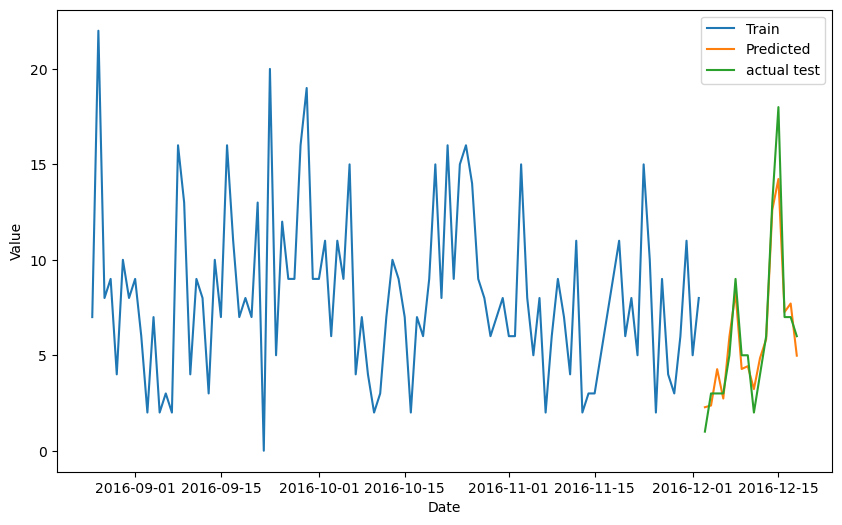

In [47]:
def plotidx(ind):
    plt.figure(figsize=(10, 6))
    mintimeIdx = test_index[ind] - look_back
    plt.plot(time_index[mintimeIdx:test_index[ind]], X_test[0][ind,:,0], label='Train')
    plt.plot(time_index[test_index][ind:ind+n_predictedValues], forecast[ind,:], label='Predicted')
    plt.plot(time_index[test_index][ind:ind+n_predictedValues], labels[test_index][ind,:], label='actual test')
    plt.xlabel('Date')
    plt.ylabel('Value')
    #plt.title(f'ARIMA Forecast (RMSLE: {rmsle:.4f})')
    plt.legend()
    plt.show()
plotidx(3)

## predict next 15 values, single model for every store/product pair

In [ ]:
def trainModelAndPredict(storeId, familyId, data6):
    pair = data6.loc[(train.store_nbr == storeId) & (train.family == familyId)]
    testPair = pair.loc[pair.dataT == 'train']
    testPair.set_index('date', inplace=True)
    time_index = testPair.index

    tf.keras.utils.set_random_seed(42)  # sets seeds for base-python, numpy and tf

    # window for lstm approach
    look_back = 100
    n_predictedValues = 16 # I need to predict 16 values

    sequences = []
    labels = []
    for i in range(testPair.shape[0]-look_back-n_predictedValues):
        window = testPair.iloc[i : i + look_back][['sales','onpromotion','holidayType']] #,'dcoilwtico',  'description','transferred']]
        label = testPair.iloc[(i + look_back) : (i + look_back + n_predictedValues)]['sales'].values#['target']  # Next data point as label
        sequences.append(window)
        labels.append(label)
    sequences, labels = np.array(sequences), np.array(labels)

    n_splits = 10
    tscv = TimeSeriesSplit(n_splits=n_splits)

    n_features = sequences.shape[2]

    testPair.dropna(inplace=True)

    # Create an LSTM model
    model = Sequential()
    model.add(Input(shape=(look_back,n_features)))
    model.add(LSTM(64, activation='relu', return_sequences=False,
                   kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', bias_initializer='zeros'))
    #model.add(LSTM(units=32, return_sequences=False))
    model.add(Dense(n_predictedValues, activation='relu'))  # Single output for univariate forecasting
    # Compile and train the model
    model.compile(optimizer='adam', loss=tf.keras.losses.MSLE, metrics=['mse'])

    for train_index, test_index in tscv.split(sequences):
        X_train, X_test = sequences[train_index], sequences[test_index]
        y_train, y_test = labels[train_index], labels[test_index]

        model.fit(X_train, y_train, epochs=5, batch_size=32,validation_data=(X_test, y_test))

    # Evaluate on the test set
    forecast = model.predict(X_test)
    rmsle = np.sqrt(mean_squared_log_error(pred, y_test))
    print(rmsle)

    # predict test data
    return model, rmsle,

# build dataset for lstm 

In [ ]:
look_back = 100
n_predictedValues = 15
train = data6.loc[data6.dataT == 'train']
train[['holidayType','description','transferred']] = train[['holidayType','description','transferred']].astype(int)
train['lag14'] = train.sales.shift(14)
train['target'] = train.sales - train.lag14
minMaxScaling = False
zScoreScaling = False
minMaxScalingOnSequence = False
zScoreScalingOnSequence = False

train.dropna(inplace=True)
#del data6
sequences = []
labels = []
categories = []
zTransMean = []
zTransStd = []

dict_zNorm = {}

for storeId in train.store_nbr.unique():

    if storeId > 1:
        break

    storeDf = train.loc[train.store_nbr == storeId]
    print('store id', storeId)
    for famIdx, family in enumerate(storeDf.family.unique()):
        print('family', family)
        if famIdx > 1:
            break
        
        familyDf = storeDf.loc[storeDf.family == family]

        if zScoreScaling:
            mean = familyDf.sales.mean()
            stdDev = familyDf.sales.std()
            familyDf.sales = (familyDf.sales - mean) / stdDev
            a = {}
            a['mean'] = mean
            a['std'] = stdDev
            dict_zNorm[str(storeId) + '_'+str(family)] = a
        elif minMaxScaling:
            max0 = max(familyDf.sales)
            min0 = min(familyDf.sales)
            familyDf.sales = (familyDf.sales - min0) / (max0 - min0) * 100
            a = {}
            a['min'] = min0
            a['max'] = max0
            dict_zNorm[str(storeId) + '_'+str(family)] = a

        c = familyDf.city.unique()
        if len(c) > 1:
            print('somehow wrong!!')
        city = c[0]
        state = familyDf.state.iloc[0]
        type = familyDf.type.iloc[0]
        cluster = familyDf.cluster.iloc[0]

        # window for lstm approach
        for i in range(familyDf.shape[0]-look_back-n_predictedValues):
            startS = i
            endS = startS+look_back
            startP = endS
            endP = startP + n_predictedValues
            subblock0 = familyDf.iloc[startS:endS] #do normalization based on past values, not future values
            subblock = familyDf.iloc[startS:endP]
            if not minMaxScaling and not zScoreScaling:
                if zScoreScalingOnSequence:
                    mean = subblock0.sales.mean()
                    stdDev = subblock0.sales.std()
                    subblock.sales = (subblock.sales - mean) / stdDev
                    a = {}
                    a['mean'] = mean
                    a['std'] = stdDev
                    dict_zNorm[str(storeId) + '_'+str(family)] = a
                elif minMaxScalingOnSequence:
                    max0 = max(subblock0.sales)
                    min0 = min(subblock0.sales)
                    subblock.sales = (subblock.sales - min0) / (max0 - min0) * 100
                    a = {}
                    a['min'] = min0
                    a['max'] = max0
                    dict_zNorm[str(storeId) + '_'+str(family)] = a


            window = subblock.iloc[0:look_back][['sales','onpromotion','dcoilwtico','holidayType','description','transferred']].to_numpy()
            label  = subblock.iloc[look_back : (look_back + n_predictedValues)]['sales'].values#['target']  # Next data point as label
            if (not np.isnan(label).any()) and (not np.isnan(window).any()):
                sequences.append(window)
                categories.append([int(storeId), int(family), int(city), int(state), int(type), int(cluster)])
                labels.append(label)
                if zScoreScaling or zScoreScalingOnSequence:
                    zTransMean.append(mean)
                    zTransStd.append(stdDev)
                elif minMaxScaling or minMaxScalingOnSequence:
                    zTransMean.append(min0)
                    zTransStd.append(max0)

sequences, labels, categories, zTransMean, zTransStd = np.array(sequences), np.array(labels), np.array(categories), np.array(zTransMean),np.array(zTransStd)
        

In [ ]:
sequences.shape, labels.shape, categories.shape
np.savez('windowed_sequences_100Lookback_15predict.npz', arr1=sequences, arr2=labels, arr3=categories)

In [ ]:
np.isnan(sequences).any(),np.isnan(labels).any(),np.isnan(categories).any()

In [ ]:
catNum = categories.shape[1]
n_features = sequences.shape[2]

# train 1 lstm for all store/product pairs

In [ ]:
from tensorflow import keras
from tensorflow.keras.models import Model
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Input,concatenate
import tensorflow as tf
tf.random.set_seed(42)
from tensorflow.keras import layers

In [ ]:
leng = sequences.shape[0]
div = int(sequences.shape[0]*0.9)
X_train = [sequences[0:div,:,:], categories[0:div,:]]
X_test =  [sequences[div:leng,:,:], categories[div:leng,:]]

y_train = labels[0:div,:]
y_test  = labels[div:leng,:]

zMean_train = zTransMean[0:div]
zStd_train = zTransStd[0:div]
zMean_test = zTransMean[div:leng]
zStd_test = zTransStd[div:leng]

In [ ]:
seq_input = Input(shape=(look_back,n_features), name='seq_input')
feat_input = Input(shape=(catNum,), name='feat_input')

lstm_out = LSTM(units=64, activation='relu', return_sequences=False)(seq_input)
#lstm_out = LSTM(units=64, activation='relu', return_sequences=False)(lstm_out)
#print(lstm_out.shape)
#feat_input1 = Dense(catNum, activation='relu')(feat_input)
combined_input = concatenate([lstm_out, feat_input])
#combined_input = Dense(64, activation='relu')(lstm_out)
output = Dense(n_predictedValues, activation='relu')(lstm_out)
model = Model(inputs=[seq_input, feat_input], outputs=output)
model.compile(optimizer='adam', loss=tf.keras.losses.MSLE, metrics=['mse'])

model.fit(X_train, y_train, epochs=10, batch_size=32,validation_data=(X_test, y_test))

In [ ]:
evalTrain = True
X0 = X_test
std = zStd_test
mean = zMean_test
yE = y_test
if evalTrain:
    X0 = X_train
    std = zStd_train
    mean = zMean_train
    yE = y_train
predZ = model.predict(X0)

if zScoreScaling or zScoreScalingOnSequence:
    print('zScoreScaling')
    pred = np.clip((predZ * np.reshape(std, (std.shape[0],1))) + np.reshape(mean, (mean.shape[0],1)), 0,1e60)
    yT = np.clip((yE * np.reshape(std, (std.shape[0],1))) + np.reshape(mean, (mean.shape[0],1)), 0, 1e60)
elif minMaxScaling or minMaxScalingOnSequence:
    print('minMaxScaling')
    min0 =  np.reshape(mean, (mean.shape[0],1))
    max0 =  np.reshape(std, (std.shape[0],1))
    pred =  predZ / 100 * (max0 - min0) + min0
    yT   =  yE/ 100 * (max0 - min0) + min0
else
    pred = predZ
    yT = yE

rmsle = np.sqrt(mean_squared_log_error(pred, yT))
print(rmsle)
pred, yT, predZ, yE

# zScore norm, msle loss
# ~0.73 with basic network, ~30 epochs, batch size 32
# ~0.94 with more lstm layers 10 epochs, bs 32

# min max scaling
# ~2.95 with basic network, ~10 epochs, bz 32

# zScore scaling
# 0.40 with basic network, 10 epochs, bz 32 -> predicts one value per 15 future values, some bug in re-transforming values

# min max scaling based on lookback
# ~1.64 basic network, 10 epochs, bz 32   // with min/max based on future values as well...
# 3.00  basic network, 10 epochs, bz 32   // with min/max based on only past 100 values



In [ ]:
max0

In [ ]:
pred = model.predict(X_test)
rmsle = np.sqrt(mean_squared_log_error(pred, y_test))
print(rmsle)
pred, y_test